<a href="https://colab.research.google.com/github/SidorenkArtem/Health_Insurance_Dataset/blob/master/data_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files
uploaded = files.upload()

Saving insurance.csv to insurance (1).csv


In [2]:
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

User uploaded file "insurance.csv" with length 55628 bytes


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.mlab as mlab
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn import metrics
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


Прежде чем приступать к написанию кода необходимо провести анализ датасета.
В начале анализа я решил посмотреть из каких полей состоит датасет. Дальше вывел основные данные, характеризующие этот датасет. Проверил его на отсутствие каких-либо данных. Этот датасет оказался польностью заполнен.

In [4]:
data = pd.read_csv("insurance.csv")
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [5]:
data.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


Количественные данные

Построил гистограммы для визуализации количественных данных. Для оценки более интересных полей, а именно 'bmi'   и 'charges', использовал box plot. Иox plot показывает интерквартильный размах распределения. На ней можно наблюдать выбросы дынных. В ходе дальнейшего анализа у нас появились выбросы(в полях 'bmi' и 'charges'). Из-за того, что люди бывают совершенно разных комплекций я решил не бороться с выбросами. Но при построении моделей я количественные данные стандартизировал( в ходе тестирования моделей стандартизация не сильно влияла на результаты).

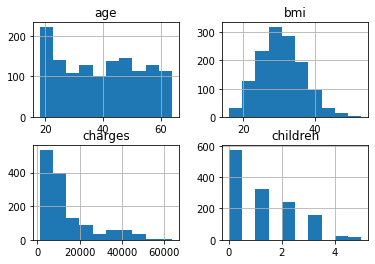

In [7]:
data.hist();

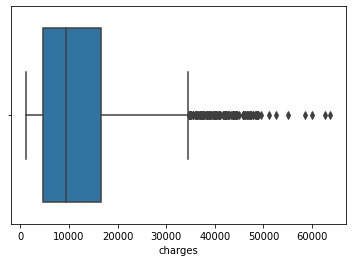

In [8]:
sns.boxplot(data['charges']);

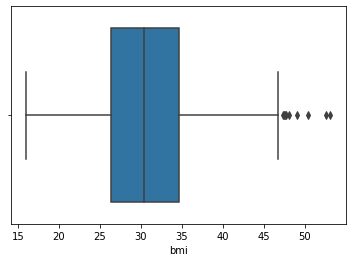

In [9]:
sns.boxplot(data['bmi']);

Категориальные признаки

Здесь хотел посмотреть на количественную составляющую категориальных полей.

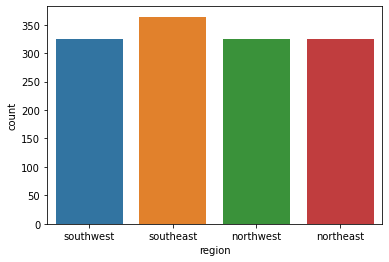

In [10]:
sns.countplot(data['region']);

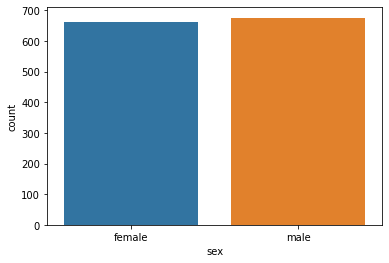

In [11]:
sns.countplot(data['sex']);

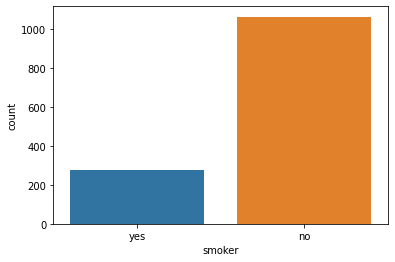

In [12]:
sns.countplot(data['smoker']);

Количественные и категориальные данные

Для анализа взаимосвязи между различными полями вывел следующий график. Наибольший интерес представляет 'charges', так как стоит задача построить модель для его предсказания. Здесь можно увидеть, что информативными распределениями данных для нас являются пары 'bmi'-'charges' и 'age'-'charges'.
Распределения двух графиков( 'bmi'-'charges' и 'age'-'charges') отдаленно напоминают линейную регрессию. Именно по этому я решил сначала попробовать ее.

In [0]:
cols = data.columns

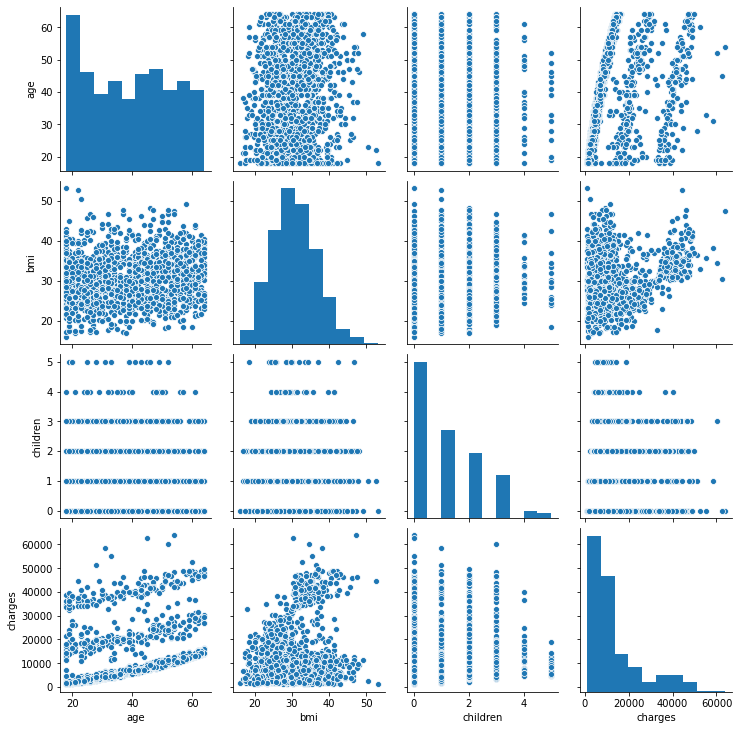

In [14]:
sns.pairplot(data[cols] , palette="husl");

Для количественных данных построил корелляционную матрицу для поиска взаимосвязей между полями. Поля 'bmi' и 'age' показывают связь с 'charges'.

In [15]:
data.corr()

,age,bmi,children,charges
age,1.000000,0.109272,0.042469,0.299008
bmi,0.109272,1.000000,0.012759,0.198341
children,0.042469,0.012759,1.000000,0.067998
charges,0.299008,0.198341,0.067998,1.000000


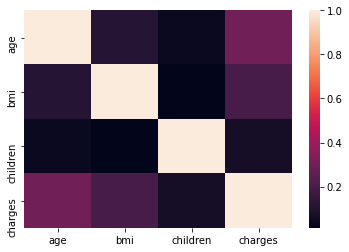

In [16]:
sns.heatmap(data.corr());

Изначально я преположил, что курение будет влиять на медицинские затраты. Мое предположение оказалось верным. Как показано ниже, курящие люди тратят на медобслуживание намного больше денежных средств, чем некурящие.

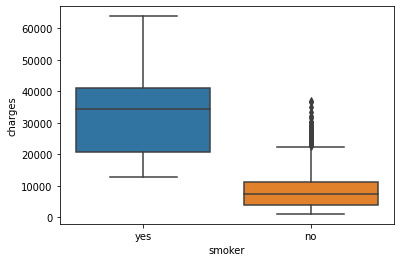

In [17]:
sns.boxplot(x='smoker', y='charges',data=data);

После построил boxplot для анализа затрат на медицину людей из разных регионов. Средние значения для каждого региона оказались приблизительно равными. Из-за этого не стоит учитывать регионы в анализе, так как они могут привнести шум.

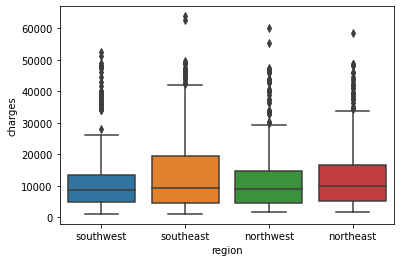

In [18]:
sns.boxplot(x='region', y='charges',data=data);

Для того, чтобы анализа взаимосвязей всех данных категориальные данные следует перевести в приемл приемлемый вид. Это делаю с помощью LabelEncoder и метода из библиотеки pandas get_dummies.

In [0]:
data = data.fillna(data.mean())
data_new = data.copy()
le = LabelEncoder()
data_new['sex'] = le.fit_transform(data_new['sex'])
data_new['smoker'] = le.fit_transform(data_new['smoker'])
df_dummles = pd.get_dummies(data_new, columns=['region'])
data_new = np.array(df_dummles)

Присутствие в данных неинформативных признаков приводит к снижению точности модели. Отбор важных признаков обеспечивает уменьшение переобучения и сокращение времени обучения. Я использовал для этого два алгоритма. Первый алгоритм основывается на дереве решений. Здесь мы обучаем классификатор ExtraTreesClassifier для определения важности каждого признака в числовом виде. По результатам работы этого дерева мы получаем следующие 4 важных признака:'bmi', 'age', 'children' и 'smoker'.

In [20]:
from sklearn.feature_selection import SelectKBest
from pandas import read_csv
import numpy as np
from sklearn.feature_selection import SelectFromModel
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectPercentile, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier

array = np.array(data_new)
X = array[:,[0,1,2,3,4,6,7,8,9]]
y = array[:,5]
X = X.astype(int)
y=y.astype(int)

forest = ExtraTreesClassifier(n_estimators=250)

forest.fit(X, y)
importances = forest.feature_importances_
print(importances)

[0.38633571 0.01698865 0.38706234 0.12951043 0.03606661 0.00779763
 0.01176581 0.01120275 0.01327008]


In [21]:
pip install Boruta

В качестве второго алгоритма я использовал Botura. По сути это обертка вокруг Random forest с параметром max_depth = 5. Он ранжирует объекты на 3 группы: 1) подтвержденные признаки, т.е. они влияют на значение целевой переменной; 2) пробные признаки, они меньше влияют и ими можно пренебречь. 3) просто шум. К 1-му типу относятся 'age','bmi', 'children' и 'smoker'.

In [22]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestRegressor

array = np.array(data)
x = data_new[:,[0,1,2,3,4,6,7,8,9]]
y = data_new[:,[5]]
#X = X.astype(int)
#y=y.astype(int)
feature_names = np.array(data.columns)
print(feature_names)

forest = RandomForestRegressor(n_jobs = -1, max_depth = 5)

boruta_selector = BorutaPy(forest, n_estimators = 'auto', random_state = 0)
boruta_selector.fit(np.array(x), np.array(y))
boruta_ranking = boruta_selector.ranking_
print(boruta_ranking);

['age' 'sex' 'bmi' 'children' 'smoker' 'region' 'charges']


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)
/usr/local/lib/python3.6/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)
/usr/local/lib/python3.6/dist-packages/boruta/boruta_py.py:384: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.estimator.fit(X, y)
/

[1 5 1 1 1 2 3 6 4]


In [0]:
le = LabelEncoder()
data['sex'] = le.fit_transform(data['sex'])
data['smoker'] = le.fit_transform(data['smoker'])
data['region'] = le.fit_transform(data['region'])

value = np.array(data[['region']])
encoded = to_categorical(value)
inverted = np.argmax(encoded[0])
encoded.astype(int)
data=data.drop(['region'],axis=1)
data['region_northwest']=encoded[:,0].transpose()
data['region_southeast']=encoded[:,1].transpose()
data['region_southwest']=encoded[:,2].transpose()
data['region_northeast']=encoded[:,3].transpose()

Теперь стоит посмотреть на корреляционную матрицу для всего датасета. Как можно заметить на поле 'charges' влияет еще одна метка 'smoker'.

In [24]:
data.describe()

,age,sex,bmi,children,smoker,charges,region_northwest,region_southeast,region_southwest,region_northeast
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,0.505232,30.663397,1.094918,0.204783,13270.422265,0.242152,0.242900,0.272048,0.242900
std,14.049960,0.500160,6.098187,1.205493,0.403694,12110.011237,0.428547,0.428997,0.445178,0.428997
min,18.000000,0.000000,15.960000,0.000000,0.000000,1121.873900,0.000000,0.000000,0.000000,0.000000
25%,27.000000,0.000000,26.296250,0.000000,0.000000,4740.287150,0.000000,0.000000,0.000000,0.000000
50%,39.000000,1.000000,30.400000,1.000000,0.000000,9382.033000,0.000000,0.000000,0.000000,0.000000
75%,51.000000,1.000000,34.693750,2.000000,0.000000,16639.912515,0.000000,0.000000,1.000000,0.000000
max,64.000000,1.000000,53.130000,5.000000,1.000000,63770.428010,1.000000,1.000000,1.000000,1.000000


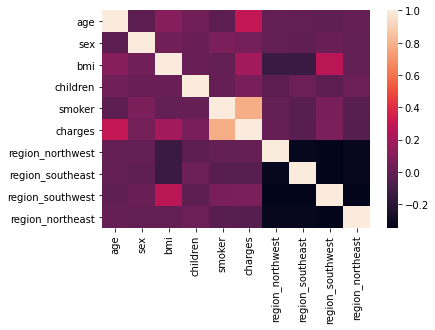

In [25]:
sns.heatmap(data.corr());

Сначала я решил запустить для обучения модель линейной регресси, дальше использовал ее в качестве эталона по отношению к другим методам. После переключился на построение моделей на основе деревьев решений. Они существенно лучше справились с поставленной задачей, чем линейная регрессия. Удобство дерева решений заклчается в том, что он не требует от пользователя выбора входных атрибутов. Алгоритм сам выберает наиболее значимые данные для построения дерева.

В ходе своего ресерча я запускал модели для всех полей, для 4-ех( 'bmi', 'age', 'children', 'smoker') и для 3-ех( 'bmi', 'age', 'smoker'). Исходя из полученных данных я сделал вывод, что набор из 4-ех( 'bmi', 'age', 'children', 'smoker') полей несет основную информацию, т.е. основные фичи - это 'bmi', 'age', 'children', 'smoker'.